In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sqlalchemy import create_engine
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import scipy.stats as st
from datetime import datetime, date, time
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

#### Data Cleaning

In [138]:
flight10k = pd.read_csv('data/flights10K.csv', index_col=0)
# remove empty flanking column
flight10k.drop(columns='no_name', inplace=True)
# if flight cancelled, remove from dataset since we want to prdecit flights that ARE leaving
flight10k = flight10k[flight10k['cancelled'] == 0] # 0 meaning not cancelled
flight10k.drop(columns=['cancelled','cancellation_code'], inplace=True)
# time count columns NaN to be filled with 0 since no time elapsed
time_counts = ['dep_delay','arr_delay','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay','total_add_gtime','longest_add_gtime','taxi_out','taxi_in']
flight10k[time_counts] = flight10k[time_counts].fillna(0)
# filling remaining empty NaN time columns with related columns information (i.e. wheels_off == dep_time/wheels_on == arr_time/actual_elapsed_time == CRS_elapsed_time) plotted earlier
flight10k['wheels_off'] = flight10k['wheels_off'].fillna(flight10k['crs_dep_time'])
flight10k['wheels_on'] = flight10k['wheels_on'].fillna(flight10k['crs_arr_time'])
flight10k['arr_time'] = flight10k['arr_time'].fillna(flight10k['crs_arr_time'])
flight10k['actual_elapsed_time'] = flight10k['actual_elapsed_time'].fillna(flight10k['crs_elapsed_time'])
flight10k['air_time'] = flight10k['air_time'].fillna(flight10k['crs_elapsed_time'])

# have a look at the dataset
flight10k.head()
flight10k.shape

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime
0,2018-06-17,WN,WN,WN,5273,WN,N299WN,5273,14492,RDU,"Raleigh/Durham, NC",15304,TPA,"Tampa, FL",1220,1220.0,0.0,16.0,1236.0,1357.0,17.0,1400,1414.0,14.0,0.0,N,100.0,114.0,81.0,1.0,587.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
1,2019-02-15,UA,UA_CODESHARE,UA,5421,OO,N787SK,5421,11109,COS,"Colorado Springs, CO",11292,DEN,"Denver, CO",1150,1142.0,-8.0,19.0,1201.0,1220.0,4.0,1242,1224.0,-18.0,0.0,N,52.0,42.0,19.0,1.0,73.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
2,2018-01-30,WN,WN,WN,492,WN,N791SW,492,11433,DTW,"Detroit, MI",10821,BWI,"Baltimore, MD",535,529.0,-6.0,30.0,559.0,703.0,2.0,715,705.0,-10.0,0.0,N,100.0,96.0,64.0,1.0,409.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
3,2019-01-15,UA,UA,UA,1822,UA,N401UA,1822,11298,DFW,"Dallas/Fort Worth, TX",11292,DEN,"Denver, CO",905,856.0,-9.0,37.0,933.0,1009.0,8.0,1018,1017.0,-1.0,0.0,N,133.0,141.0,96.0,1.0,641.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
4,2018-03-26,DL,DL,DL,2149,DL,N374NW,2149,12953,LGA,"New York, NY",13487,MSP,"Minneapolis, MN",1123,1129.0,6.0,37.0,1206.0,1339.0,3.0,1341,1342.0,1.0,0.0,N,198.0,193.0,153.0,1.0,1020.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


(9855, 39)

In [139]:
# function to quickly display columns with remaining null values -- used iteratively to quickly clean the df in the cell above
def whatsleft(df):
    '''Functions like df.isnull().sum() except only shows the remaining columns with values missing'''
    nan_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
    print('Column \t\t # Nan Values')
    return df[nan_cols].isnull().sum()

whatsleft(flight10k)

Column 		 # Nan Values


first_dep_time    9778
dtype: int64

In [140]:
# first_dep_time: First Gate Departure Time at Origin Airport
# 9778 / 9855 empty =  99+% NaN -- let's drop this column
flight10k.drop(columns='first_dep_time', inplace=True)

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

plot distribution of arrival delays

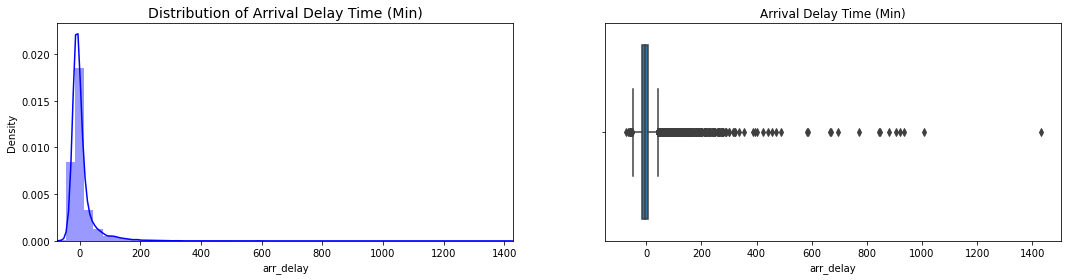

In [141]:
fig, ax = plt.subplots(1,2, figsize=(18,4));
sns.distplot(flight10k['arr_delay'], color='b', ax=ax[0]);
ax[0].set_title('Distribution of Arrival Delay Time (Min)', fontsize=14);
ax[0].set_xlim([min(flight10k['arr_delay'].values), max(flight10k['arr_delay'].values)]);

sns.boxplot(flight10k['arr_delay'], ax=ax[1]);
ax[1].set_title('Arrival Delay Time (Min)');
plt.show();

In [142]:
flight10k['arr_delay'].describe()

count    9855.000000
mean        5.681684
std        51.206438
min       -75.000000
25%       -15.000000
50%        -6.000000
75%         8.000000
max      1430.000000
Name: arr_delay, dtype: float64

Observaton: high stdev and data spread. Need to remove outliers:

In [143]:
def rem_outliers(df, col):
    ''' Remove outliers which fall outside of 3 standard deviations above and below the mean of the data set
            Input
                (0) dataframe containing the data
                (1) column to remove outliers from
            Output
                rows of df which are classified as outliers in the specified column are directly removed
                print out stating count of outliers removed '''
    mean, cutoff = np.mean(df[col]), np.std(df[col]) * 3   # 3 stddev outside the mean
    lower, upper = mean - cutoff, mean + cutoff
    outliers = [x for x in df[col] if x < lower or x > upper]
    df.drop(df[(df[col] > upper) | (df[col] < lower)].index, inplace=True)
    return f'{len(outliers)} outliers removed'

In [144]:
rem_outliers(flight10k, 'arr_delay')

'138 outliers removed'

plot distribution of arrival delays after outlier removal

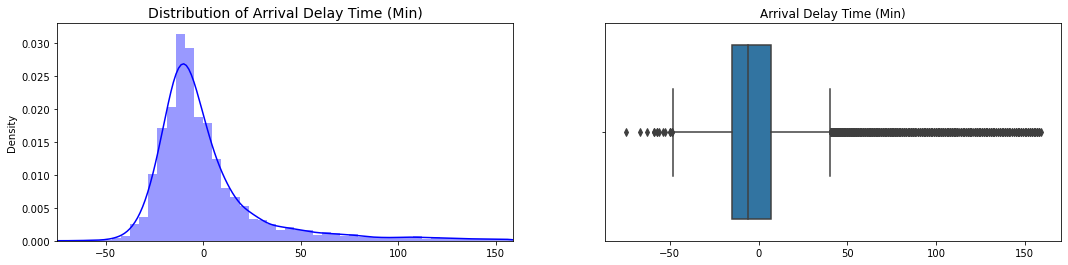

In [145]:
arr_delay = flight10k['arr_delay'].values

fig, ax = plt.subplots(1,2, figsize=(18,4));
sns.distplot(arr_delay, color='b', ax=ax[0]);
ax[0].set_title('Distribution of Arrival Delay Time (Min)', fontsize=14);
ax[0].set_xlim([min(arr_delay), max(arr_delay)]);

sns.boxplot(arr_delay, ax=ax[1]);
ax[1].set_title('Arrival Delay Time (Min)');
plt.show();

In [146]:
flight10k['arr_delay'].describe()

count    9717.000000
mean        1.597098
std        29.432871
min       -75.000000
25%       -15.000000
50%        -6.000000
75%         7.000000
max       159.000000
Name: arr_delay, dtype: float64

test null hypothesis of normal distribution using Shapiro-Wilks test via scipy.stats

In [147]:
pval = st.shapiro(flight10k['arr_delay'])[1]
if pval > 0.05:
    print('Accept Null Hypothesis of Normal Distribution')
elif pval < 0.05:
    print('Reject Null Hypothesis, Not Normal Distribution')

Reject Null Hypothesis, Not Normal Distribution


#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [148]:
# convert date to datetime in order to grab the month
flight10k['fl_date'] = pd.to_datetime(flight10k['fl_date'])
flight10k['fl_month'] = flight10k['fl_date'].dt.month

monthly = flight10k[['fl_month','arr_delay']].groupby('fl_month').agg('mean')
monthly.reset_index(inplace=True)
monthly.sort_values('arr_delay', ascending=False)

,fl_month,arr_delay
5,6,5.714959
6,7,5.007491
7,8,4.000000
3,4,1.534031
4,5,1.518343
10,11,1.187042
9,10,0.524318
1,2,0.410687
0,1,0.259109
2,3,-0.257485


We see that this highest delays occur during the summer months -- this might correlate to a higher traffic season as people are taking vacations

In [149]:
# same as above but let's add in a count of flights for explanation
monthly = flight10k[['fl_month','arr_delay','mkt_carrier_fl_num']].groupby('fl_month').agg({'arr_delay':'mean','mkt_carrier_fl_num':'count'})
monthly.reset_index(inplace=True)
monthly.rename(columns={'arr_delay':'avg_arr_delay','mkt_carrier_fl_num':'count_flights'}, inplace=True)
monthly.sort_values('avg_arr_delay', ascending=False)

,fl_month,avg_arr_delay,count_flights
5,6,5.714959,849
6,7,5.007491,801
7,8,4.000000,890
3,4,1.534031,764
4,5,1.518343,845
10,11,1.187042,818
9,10,0.524318,843
1,2,0.410687,655
0,1,0.259109,741
2,3,-0.257485,835


count of flights did not explain higher delays for some months -- let's have a look at all the different delay types within the months

In [150]:
delays = flight10k[['fl_month','dep_delay','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay','arr_delay']]
delay_means = delays.groupby('fl_month').agg('mean').sort_values('arr_delay', ascending=False)
delay_means.reset_index(inplace=True)
delay_means

,fl_month,dep_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,arr_delay
0,6,10.184923,3.202591,0.702002,3.049470,0.000000,4.984688,5.714959
1,7,9.230961,3.172285,0.357054,3.508115,0.000000,4.444444,5.007491
2,8,8.237079,3.016854,0.567416,3.077528,0.024719,4.173034,4.000000
3,4,6.693717,2.477749,0.227749,2.308901,0.037958,3.607330,1.534031
4,5,6.590533,2.427219,0.478107,2.655621,0.000000,3.817751,1.518343
5,11,5.734719,2.343521,0.319071,2.221271,0.000000,3.685819,1.187042
6,10,4.431791,1.823250,0.090154,2.398577,0.000000,3.150652,0.524318
7,2,6.158779,2.964885,0.346565,3.326718,0.000000,3.000000,0.410687
8,1,6.685560,2.757085,0.350877,2.363023,0.000000,3.712551,0.259109
9,3,5.452695,2.176048,0.319760,2.189222,0.025150,2.655090,-0.257485


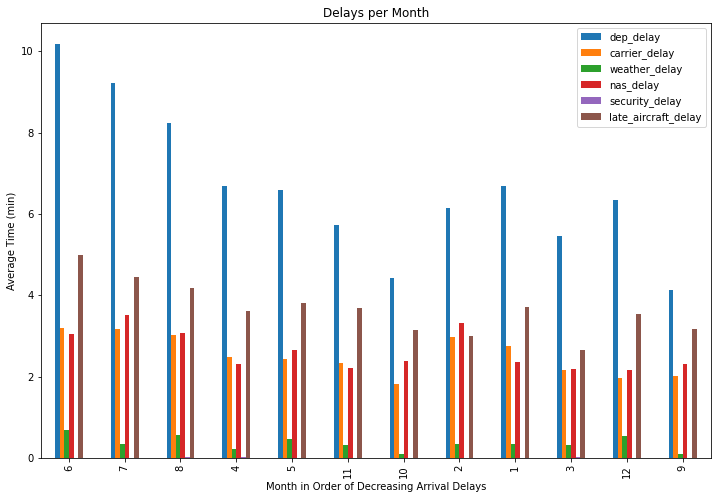

In [151]:
delay_means.plot(x="fl_month", y=['dep_delay','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay'], kind="bar", figsize=(12,8));
plt.title('Delays per Month');
plt.xlabel('Month in Order of Decreasing Arrival Delays');
plt.ylabel('Average Time (min)');

From other delays, we can see that we have increased departure delays and late aircraft delays which correlate to the increased arrival delays

can we check the count of seats on flights by pulling in the passengers?

In [152]:
pass10k = pd.read_csv('data/passengers10K.csv', index_col=0) # this has a month listed which we could group by to count the seats
pass10k.head()

,departures_scheduled,departures_performed,payload,seats,passengers,freight,mail,distance,ramp_to_ramp,air_time,unique_carrier,airline_id,unique_carrier_name,region,carrier,carrier_name,carrier_group,carrier_group_new,origin_airport_id,origin_city_market_id,origin,origin_city_name,origin_country,origin_country_name,dest_airport_id,dest_city_market_id,dest,dest_city_name,dest_country,dest_country_name,aircraft_group,aircraft_type,aircraft_config,year,month,distance_group,class,data_source
0,0.0,1.0,2803.0,14.0,6.0,0.0,0.0,5582.0,0.0,0.0,12Q,21423,Unijet,I,12Q,Unijet,0,0,12900,30920,LBG,"Paris, France",FR,France,14771,32457,SFO,"San Francisco, CA",US,United States,7,775,1,2015,11,12,L,IF
1,4.0,4.0,274750.0,0.0,0.0,130961.0,7580.0,491.0,359.0,295.0,5X,19917,United Parcel Service,D,5X,United Parcel Service,3,3,14730,33044,SDF,"Louisville, KY",US,United States,13198,33198,MCI,"Kansas City, MO",US,United States,6,622,2,2015,5,1,G,DU
2,53.0,47.0,470000.0,2350.0,1537.0,0.0,0.0,642.0,5760.0,4510.0,EV,20366,ExpressJet Airlines LLC,D,EV,ExpressJet Airlines Inc.,3,3,14730,33044,SDF,"Louisville, KY",US,United States,11618,31703,EWR,"Newark, NJ",US,United States,6,675,1,2016,2,2,F,DU
3,52.0,47.0,1405300.0,5170.0,4400.0,6976.0,11941.0,1029.0,8875.0,7163.0,DL,19790,Delta Air Lines Inc.,D,DL,Delta Air Lines Inc.,3,3,12478,31703,JFK,"New York, NY",US,United States,13487,31650,MSP,"Minneapolis, MN",US,United States,6,608,1,2018,3,3,F,DU
4,1.0,1.0,10000.0,50.0,39.0,0.0,0.0,109.0,56.0,31.0,OO,20304,SkyWest Airlines Inc.,D,OO,SkyWest Airlines Inc.,3,3,11898,31898,GFK,"Grand Forks, ND",US,United States,10631,30631,BJI,"Bemidji, MN",US,United States,6,629,1,2018,6,1,F,DU


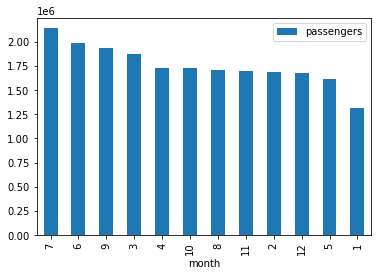

In [153]:
passmonthly = pass10k[['month','passengers']].groupby('month').agg('sum').sort_values('passengers', ascending=False)
passmonthly.plot(kind='bar');

I don't think joining this on will make much explanation to increased delays for the summer months

#### What other parameters can we use to explain *what the reason could be* for higher traffic months?

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [154]:
# Oliver's insight here

#### **Task 4**: How are taxi times changing during the day? Does higher traffic lead to bigger taxi times?

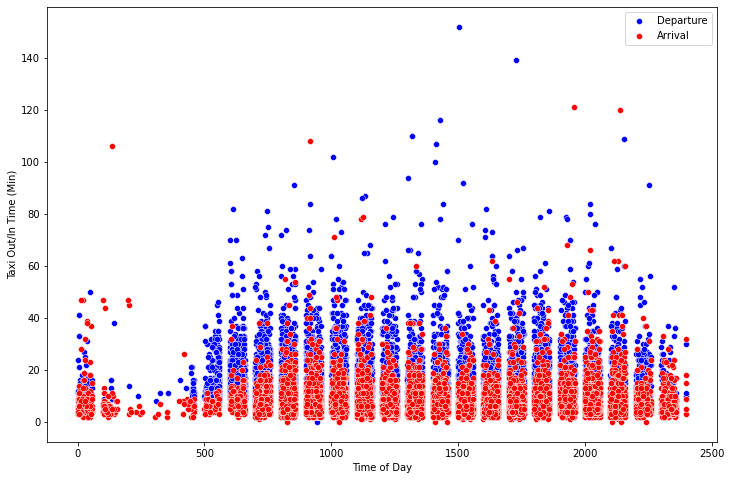

In [155]:
# taxi times during the day
taxi = flight10k[["fl_date", "dep_time", "taxi_out", "arr_time", "taxi_in"]]
taxi.dropna(axis=0, inplace=True) # if we have no information, you are useless to me

fig, ax = plt.subplots(figsize=(12,8));
sns.scatterplot('dep_time', 'taxi_out', data=taxi, color='b', ax=ax, label='Departure');
sns.scatterplot('arr_time','taxi_in', data=taxi, color='r', ax=ax, label='Arrival');
ax.set_xlabel('Time of Day');
ax.set_ylabel('Taxi Out/In Time (Min)');
plt.legend();
plt.show();

Flying in the middle of the day has higher delays during the taxi in and out

In [ ]:
# Does higher traffic lead to bigger taxi times?
    ## how do we measure traffic?

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [ ]:
#delays = flight10k[['fl_date','dep_delay','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay','arr_delay','air_time']]


#### **Task 6**: How many states cover 50% of US air traffic? 

See individual Task6 notebook due to plotly plotting issues within this notebook. Images will be imported back here.

In [20]:
# code snippet from Task6 notebook for result
def get_state(df, col, new_col):
    value=[]
    for i in df[col]:
        i = str(i)
        value.append(i[-2:])
    df[new_col] = value        
get_state(flight10k, 'origin_city_name', 'state_origin')
get_state(flight10k, 'dest_city_name', 'state_dest')
origin = flight10k[['mkt_carrier_fl_num','state_origin']].groupby('state_origin').agg('count').sort_values('mkt_carrier_fl_num',ascending=False).rename(columns={'mkt_carrier_fl_num':'nflights'})
origin['pflights'] = origin['nflights']/sum(origin['nflights'])*100
origin.reset_index(inplace=True)
top50 = []
perc = 0
for index, row in origin.iterrows():
    perc += row['pflights']
    if perc > 50:
        break
    top50.append(row['state_origin'])

print('Number of US States comprising 50% US air traffic: ', len(top50))
print('US States: ', top50)

Number of US States comprising 50% US air traffic:  7
US States:  ['TX', 'CA', 'FL', 'IL', 'GA', 'NY', 'NC']


<img src='images/choropleth_USflights_origin.png'>
<img src='images/choropleth_USflights_dest.png'>

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

Logic: if arr_delay < dep_delay, then we know they flew faster to compensate for the dep_delay. Let's get a new subset of the whole dataframe, grabbing *only* the arr_delay and dep_delay

In [21]:
# Postgres username, password, and database name
POSTGRES_ADDRESS = 'mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com'
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = os.environ['midterm_user']
POSTGRES_PASSWORD = os.environ['midterm_pass']
POSTGRES_DBNAME = 'mid_term_project'
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=POSTGRES_USERNAME,
               password=POSTGRES_PASSWORD,
               ipaddress=POSTGRES_ADDRESS,
               port=POSTGRES_PORT,
               dbname=POSTGRES_DBNAME))
# Create the connection
database = create_engine(postgres_str)

# new subset of delays for whole dataset if possible, pre-screen for NaN/early (neg) and non-cancelled
#delays_req = pd.read_sql_query('''SELECT dep_delay, arr_delay FROM flights WHERE dep_delay > 0 AND cancelled <> 1;''', database)
#delays_req.to_csv('data/delays.csv')

In [22]:
delays = pd.read_csv('data/delays.csv', index_col=0)
delays.head()
delays.shape

,dep_delay,arr_delay
0,151.0,186.0
1,1.0,-10.0
2,46.0,17.0
3,71.0,62.0
4,41.0,35.0


(5335958, 2)

In [23]:
#test if dep_delay > arr_delay, then return 1 for 
def fast(df):
    '''If the arrival delay count in min is less than the departure delay, 
            then return 1 for 'fast' since the plane must have gone faster to make-up for the delayed departure
            else return 0 for 'not fast' as the arrival delay was as long or longer than departure delays'''
    if df['dep_delay'] > df['arr_delay']:
        return 1 # sped up during flight
    else: 
        return 0 # remained behind schedule

# caution in restarting kernel, this cell takes a while but is necessary to plot task 7 in the next cell    
delays['fast'] = delays.apply(fast, 1)

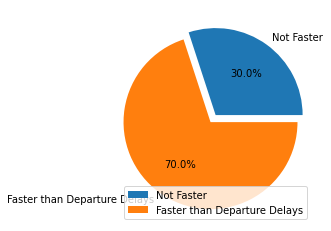

In [24]:
count_speed = delays.groupby('fast').count()['dep_delay']
explode = (0, 0.1) # this makes the graph look fancy with a piece of the pie coming out
fig, ax = plt.subplots();
ax.pie(count_speed.values, explode=explode, labels=["Not Faster", "Faster than Departure Delays"], autopct='%1.1f%%'); # loading the perc of pie for each piece
ax.set_title=("Depature Delayed Flights");
plt.legend(loc='lower center');
plt.savefig('images/t7_faster_flightdelay.png');

Yes, planes often fly faster when there is the departure delay

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

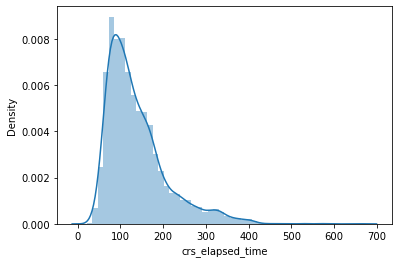

In [156]:
# need to distinguish what makes a 'long, short or medium' haul flight. then count each occurance against dep_time
# use crs_elapsed_time since we know this information before the flight takes off: 'CRS Elapsed Time of Flight, in Minutes'
sns.distplot(flight10k['crs_elapsed_time']);

#### Domain Knowledge on Flight Haul Durations 
[Source](http://themcggroup.com/blog/the-differences-between-longhaul-and-shorthaul-piloting/bp67/#:~:text=Short-haul%20is%20a%20flight,lasting%20between%203-6%20hours)
* Short-haul is a flight lasting anywhere from 30 minutes to 3 hours. 
* Medium-haul is defined by flights lasting between 3-6 hours.
* Thus, Long-haul is defined by longer than 6 hours


In [157]:
def haul(df, col):
    '''Determine if flight length is SHORT, MEDIUM or LONG based on expected elapsed flight time. 
            Input 
            (0) df containing flight information, 
            (1) column containing the elapsed flight time in minutes
                  
            Output
            'haul_length' column determining haul length category per row in df'''
    length=[]
    for i in df[col]:
        if i < (3*60): # up to 3 hours
            length.append('short')
        elif (i >= (3*60)) and (i < (6*60)): # 3-6 hours
            length.append('medium')
        elif i >= (6*60):
            length.append('long') # 6+ hours
    df['haul_length'] = length
    
def gethour(df,col):
    '''Convert hhmm to hh (24-hr) hour-only output
            Input 
            (0) df containing flight information, 
            (1) column containing the hhmm time
                  
            Output
            rewrite on input column in rounded hh format'''
    values = []
    for i in df[col]:
        mins = (i % 100) / 60 
        hour = i // 100
        hh = round(hour+mins)
        values.append(hh)
    df[col] = values

In [158]:
haul(flight10k, 'crs_elapsed_time')
gethour(flight10k, 'crs_dep_time') # departure time given by CRS before flight takes off (as seen in flights_test)

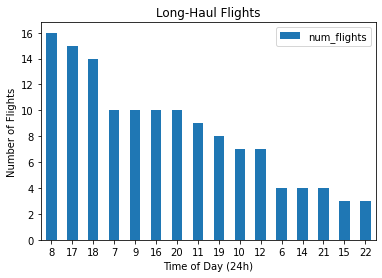

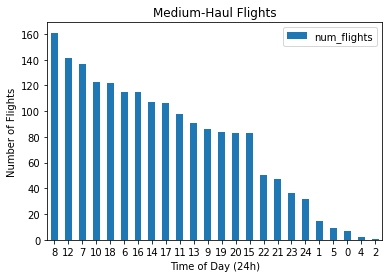

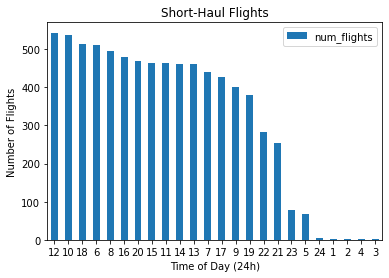

In [185]:
long = flight10k['haul_length'] == 'long'
med = flight10k['haul_length'] == 'medium'
short = flight10k['haul_length'] == 'short'

L = flight10k[long][['crs_dep_time','mkt_carrier_fl_num']].groupby('crs_dep_time').agg('count').sort_values('mkt_carrier_fl_num',ascending=False).rename(columns={'mkt_carrier_fl_num':'num_flights'});
ax = L.plot(kind='bar', title='Long-Haul Flights',rot=0);
ax.set(xlabel='Time of Day (24h)', ylabel='Number of Flights');
M = flight10k[med][['crs_dep_time','mkt_carrier_fl_num']].groupby('crs_dep_time').agg('count').sort_values('mkt_carrier_fl_num',ascending=False).rename(columns={'mkt_carrier_fl_num':'num_flights'})
ax = M.plot(kind='bar', title='Medium-Haul Flights',rot=0);
ax.set(xlabel='Time of Day (24h)', ylabel='Number of Flights');
S = flight10k[short][['crs_dep_time','mkt_carrier_fl_num']].groupby('crs_dep_time').agg('count').sort_values('mkt_carrier_fl_num',ascending=False).rename(columns={'mkt_carrier_fl_num':'num_flights'})
ax = S.plot(kind='bar', title='Short-Haul Flights',rot=0);
ax.set(xlabel='Time of Day (24h)', ylabel='Number of Flights');

* We can see that LONG haul flights are most commonly departing in the morning (8am) followed closely by after work (5 and 6pm)
* We can see that MEDIUM haul flights are most commonly departing in the mornings (8am, noon, 7am, 10am) 
* We can see that SHORT haul flights are most commonly departing in the midday (12pm and 10am) followed closely by before/after work times (6pm and 6am)

### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?